In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import shap
import sklearn.metrics as metrics
import xgboost as xgb

Read expression data matrix and ground truth, and fix global data variables


In [126]:
COND = '100'#5 or 40 or 100

data_file = 'data/'+COND+'_mr_50_cond/simulated_noNoise.txt' #5 or 40 or 100
grn_file = 'data/'+COND+'_mr_50_cond/bipartite_GRN.csv'

data = pd.read_csv(data_file, sep="\t", header=0)
grn_df = pd.read_csv(grn_file, sep = ",", header = None, names=['TF_ID', 'G_ID'])
grn_df['W_true'] = 1

N_genes = 100  # total no. of genes
N_TFs = N_genes

Fix hyperparameters

In [127]:
n_estimators=1000  # number of trees in the forest (as per GENIE paper)
criterion='squared_error'  # variance reduction equivalent
max_features = int(np.round(np.sqrt(N_genes-1))) # max no. of features to use in each tree (as per GENIE paper)
random_state = 42  # for reproducibility


Fit models per gene

In [128]:
# Normalize Expression data to unit-variance
data_n = StandardScaler(with_mean=False).fit_transform(data.to_numpy())

# Initialize matrices
W = np.zeros(shape=(N_genes,N_TFs))
W_shap = np.zeros(shape=(N_genes,N_TFs))
Fscores = np.zeros(shape=(N_genes,))

for j in np.arange(0,N_genes):
    # read TF and gene expression data X and Gj
    X, Gj= data_n[:,:100], data_n[:,N_genes+j]

    # NOTE: Do we want/need to reserve some genes for validation?
    #       GENIE3 uses all but the current target gene's expression data
    #       while whe are only using the TFs.

    # fit an RF model to predict gene expression from TF
    M_rf = RandomForestRegressor(criterion=criterion, n_estimators=n_estimators, max_features=max_features, random_state=random_state).fit(X,Gj)

    # train score
    Fscores[j] = M_rf.score(X,Gj)

    # Get the weights for all edges connecting TFs to gene j
    W[j,:] = M_rf.feature_importances_

    # look at feature importance based on SHAP values
    explainer = shap.TreeExplainer(M_rf)
    shap_values = explainer(X)
    W_shap[j,:] = np.mean(np.abs(shap_values.values), axis=0)



Visualize importance scores for all genes

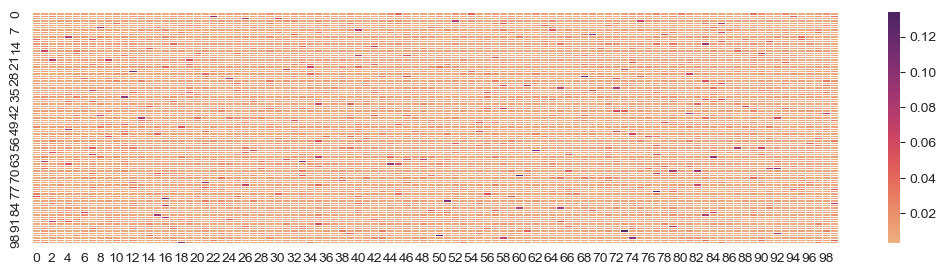

In [129]:
W_df = pd.DataFrame(np.abs(W), dtype=np.float32)

plt.figure(figsize=(13, 3))
ax = sns.heatmap(W_df,
            cmap = "flare",
            linewidths=0.5)

Visualize importance scores for all genes

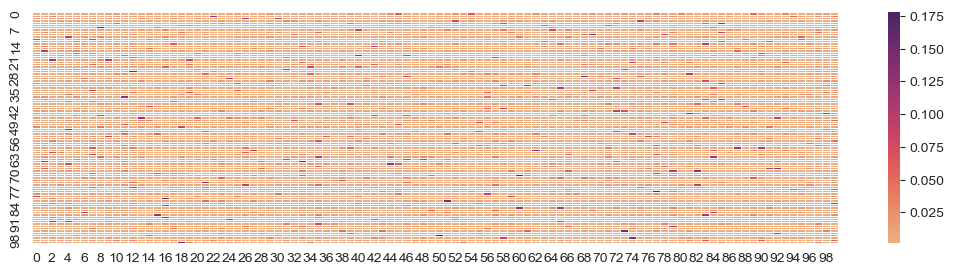

In [130]:
W_shap_df = pd.DataFrame(np.abs(W_shap), dtype=np.float32)

plt.figure(figsize=(13, 3))
ax = sns.heatmap(W_shap_df,
            cmap = "flare",
            linewidths=0.5)


Format weight's matrix for comparison again baseline and GENIE3

In [131]:
grn_pred = pd.melt(W_df.reset_index(), id_vars = 'index', var_name='TF_ID', value_name='W_pred').rename(columns={'index': 'G_ID'})

grn_pred['G_ID'] = grn_pred['G_ID'].astype(np.int64) + 100
grn_pred['TF_ID'] = grn_pred['TF_ID'].astype(np.int64)
# grn_pred = grn_pred.reset_index(inplace=True)

result = pd.merge(grn_pred,grn_df, on=['G_ID', 'TF_ID'], how='left')
result['W_true'] = result['W_true'].fillna(int(0)) == 1.0


Format weight's matrix for comparison again baseline and GENIE3 - SHAP

In [132]:
grn_pred_shap = pd.melt(W_shap_df.reset_index(), id_vars = 'index', var_name='TF_ID', value_name='W_pred').rename(columns={'index': 'G_ID'})

grn_pred_shap['G_ID'] = grn_pred_shap['G_ID'].astype(np.int64) + 100
grn_pred_shap['TF_ID'] = grn_pred_shap['TF_ID'].astype(np.int64)
# grn_pred = grn_pred.reset_index(inplace=True)

result_shap = pd.merge(grn_pred_shap,grn_df, on=['G_ID', 'TF_ID'], how='left')
result_shap['W_true'] = result_shap['W_true'].fillna(int(0)) == 1.0


In [133]:
print(metrics.roc_auc_score(result['W_true'],result['W_pred']))
print(metrics.roc_auc_score(result_shap['W_true'],result_shap['W_pred']))

0.8916503753320594
0.9016922913872749


In [134]:
AUC_pGene = np.zeros(shape=(N_genes,))
AUC_shap_pGene = np.zeros(shape=(N_genes,))
for i in range(100):
    result_gene = result.iloc[i::100,:]
    result_gene_shap = result_shap.iloc[i::100,:]
    AUC_pGene[i] = metrics.roc_auc_score(result_gene['W_true'], result_gene['W_pred'])
    AUC_shap_pGene[i] = metrics.roc_auc_score(result_gene_shap['W_true'], result_gene_shap['W_pred'])

In [135]:
print(AUC_pGene.mean())
print(AUC_shap_pGene.mean())

0.9006260988857016
0.9099240885168604


In [136]:
# W_df_agg = W_df.groupby("TF_ID", sort=False, as_index=False).agg(['mean', 'std'])['Imp'].reset_index()
# W_df_agg = W_df_agg.sort_values(by='mean', ascending= False)
#
# W_df_agg

In [137]:
# # Set the figure size
# plt.figure(figsize=(15,5))
#
# # plot a bar chart
# ax = sns.barplot(x="TF_ID", y="Imp",
#                  data=W_df, errorbar='sd',
#                  order=W_df_agg.index,
#                  capsize=.2, errwidth=1.5,
#                  errcolor="black")
# ax.set_xlabel('TF ID')
# ax.set_ylabel('F. Importance')
# ax.set_title("Global Ranking")
# ax.tick_params(axis = 'x',labelrotation=90)

In [138]:

    # # wj.nlargest(20).plot(kind = 'barh')
    #
    # #
    # # # plot
    # # shap.summary_plot(shap_values, X)
    # pass



